This is the offline notebook that will pull the information in from csv files and peform the modeling.

In [244]:
import pandas as pd
import numpy as np

nfl_qb_df = pd.read_csv('master_nfl_qb_df_filter.csv')
college_qb_df = pd.read_csv('master_qb_df.csv')
print('NFL df shape:', nfl_qb_df.shape)
print('College df shape:', college_qb_df.shape)

NFL df shape: (174, 129)
College df shape: (1438, 54)


Now that we have the nfl and college qb df's loaded, we need to do a little data processing with the nfl dataframe to remove the non quarterbacks that are still remaining.

In [245]:
nfl_qb_df = nfl_qb_df[nfl_qb_df['qb_record'].notnull()]
print('NFL df shape:', nfl_qb_df.shape)

NFL df shape: (158, 129)


1. Need to get list of Pro-Bowl QB's and add that to the nfl qb dataframe.  
2. Then I will need a subset of qb's that have played at least 5 years, (started at least half their games), and have gone to a probowl.  
3. From there, I can then make a column that says "Success, true/false" and then send that back to the college qb df.

In [246]:
nfl_qb_df['Player']

0        Rodney Peete
2        Charlie Frye
3         Chris Simms
6       Brodie Croyle
7        Chris Weinke
            ...      
168       Nick Foles 
169    Jameis Winston
170         Matt Ryan
171       Elvis Grbac
173     Philip Rivers
Name: Player, Length: 158, dtype: object

In [247]:
# we will read in the original dataset of the NFL QB's to get the list of Pro Bowl Quarterbacks

original_nfl_qb_df = pd.read_excel('NFL_QBS_2000-2015.xlsx', sheet_name='OriginalData')

def probowl(qb_name):
    if '*' in qb_name:
        return True
    else:
        return False

original_nfl_qb_df = original_nfl_qb_df[original_nfl_qb_df['Pos'] != 'wr']
original_nfl_qb_df = original_nfl_qb_df[(original_nfl_qb_df['Pos'] == 'QB') | (original_nfl_qb_df['Pos'] == '/qb') | (original_nfl_qb_df['Pos'].isnull()) | (original_nfl_qb_df['Pos'] == 'qb')]

original_nfl_qb_df['ProBowl'] = original_nfl_qb_df['Player'].apply(probowl)


nfl_pro_bowl_qb_list = original_nfl_qb_df[original_nfl_qb_df['ProBowl'] == True]

nfl_pro_bowl_qb_list = nfl_pro_bowl_qb_list['Player'].to_list()
print(len(nfl_pro_bowl_qb_list))
nfl_pro_bowl_qb_list = [x.replace("+", "") for x in nfl_pro_bowl_qb_list]
nfl_pro_bowl_qb_list = [x.replace("*", "") for x in nfl_pro_bowl_qb_list]
nfl_pro_bowl_qb_list = list(set(nfl_pro_bowl_qb_list))

# now that we have our list, we can create our column in the nfl_qb_df that shows those quarterbacks who have been selected to a pro-bowl
pro_bowl_qb = pd.DataFrame({'name': nfl_pro_bowl_qb_list, 'Boolean': True})
nfl_qb_df['Pro Bowl Selection'] = nfl_qb_df['Player'].isin(pro_bowl_qb['name'])
nfl_qb_df['Pro Bowl Selection']





195


0      False
2      False
3      False
6      False
7      False
       ...  
168     True
169     True
170     True
171     True
173     True
Name: Pro Bowl Selection, Length: 158, dtype: bool

In [248]:
'''# Now we need a column denoting those NFL QB's who have started at least half of their games 
(datframe is already filterd to those qb's that have played at least 5 years).'''

# Successful QB column
# I believe it is safe to assume that if a qb has made the pro-bowl, they have started at least half of their
# games, so we will make the column denote 1 for those that 

nfl_qb_df['Pct_Games_Started'] = nfl_qb_df['games_started']/nfl_qb_df['games']
# nfl_qb_df['Pct_Games_Started']

def start_hurdle(percentage):
    if percentage >= 0.50: 
        return 1 
    else: 
        return 0

nfl_qb_df['Successful_QB'] = nfl_qb_df['games_started'].apply(start_hurdle)


In [249]:
# Now we can carry this list of qb's back to the college dataframe to denote those quarterbacks that were successful.

# master_qb_df.csv has the list of names under the column 'name'
# nfl_qb_df_filter has list of names under the column 'Player'

success_nfl_qb_df = nfl_qb_df[['Player', 'Successful_QB']]
print(success_nfl_qb_df.shape)

final_df = college_qb_df.merge(success_nfl_qb_df, left_on='name', right_on='Player', how='left')
final_df['Successful_QB'] = final_df['Successful_QB'].fillna(0)
final_df['Player'] = final_df['Player'].fillna(final_df['name'])



(158, 2)


In [250]:

# Delete columns containing either 35% or more than 35% NaN Values
perc = 35.0
min_count =  int(((100-perc)/100)*final_df.shape[0] + 1)
final_df = final_df.dropna( axis=1, 
                thresh=min_count)
final_df = final_df.drop(columns=['Unnamed: 0'])
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1438 entries, 0 to 1437
Data columns (total 26 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   adjusted_yards_per_attempt        1365 non-null   float64
 1   completed_passes                  1365 non-null   float64
 2   interceptions_thrown              1365 non-null   float64
 3   name                              1438 non-null   object 
 4   pass_attempts                     1365 non-null   float64
 5   passing_completion                1365 non-null   float64
 6   passing_touchdowns                1365 non-null   float64
 7   passing_yards                     1365 non-null   float64
 8   passing_yards_per_attempt         1365 non-null   float64
 9   player_id                         1438 non-null   object 
 10  plays_from_scrimmage              1381 non-null   float64
 11  points                            987 non-null    float64
 12  positi

Feature: 0 is level_0 and the score is: 0.00925
Feature: 1 is index and the score is: 0.00925
Feature: 2 is adjusted_yards_per_attempt and the score is: 0.00476
Feature: 3 is completed_passes and the score is: -0.01337
Feature: 4 is interceptions_thrown and the score is: 0.00864
Feature: 5 is pass_attempts and the score is: -0.15419
Feature: 6 is passing_completion and the score is: 0.00061
Feature: 7 is passing_touchdowns and the score is: 0.01855
Feature: 8 is passing_yards and the score is: 0.21708
Feature: 9 is passing_yards_per_attempt and the score is: -0.00113
Feature: 10 is plays_from_scrimmage and the score is: 0.17490
Feature: 11 is points and the score is: 0.27017
Feature: 12 is quarterback_rating and the score is: -0.00676
Feature: 13 is rush_attempts and the score is: -0.22337
Feature: 14 is rush_touchdowns and the score is: 0.00878
Feature: 15 is rush_yards and the score is: 0.11329
Feature: 16 is rush_yards_per_attempt and the score is: -0.00006
Feature: 17 is rushing_an

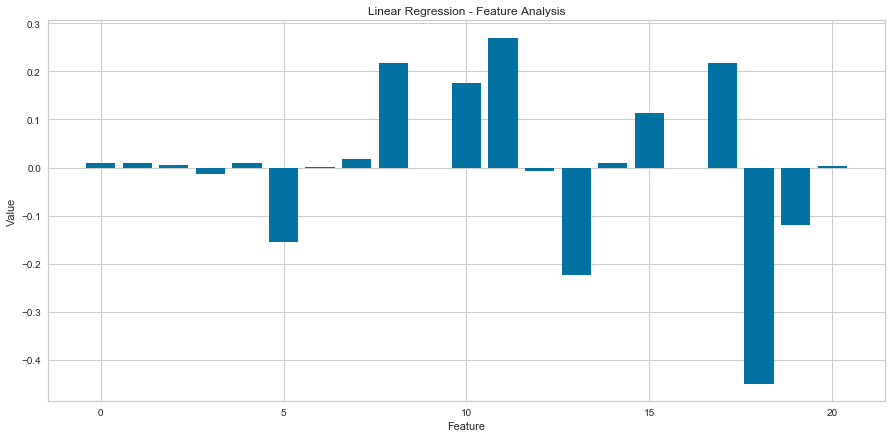

In [254]:
# Ready for feature importance selection.
# Using Linear Regression
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# need to drop columns that are something other than numbers (name, player_id, position, season, Player)
# final_df = final_df.drop(columns=['name', 'player_id', 'position', 'season', 'team_abbreviation','Player'])
# final_df = final_df.reset_index()

final_df = final_df.fillna(0)
# print(final_df.info())

# Scaling the data
model = LinearRegression()
X = final_df.loc[:,final_df.columns != 'Successful_QB']
y = final_df['Successful_QB']

columns = X.columns
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_std = pd.DataFrame(X_std, columns = columns)
# X_std = X_std.drop(columns=['level_0', 'index'])
# print(X_std.head())


model.fit(X_std,y)
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature:', str(i), 'is', X.columns[i], 'and the score is: %.5f' % (v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.title('Linear Regression - Feature Analysis')
plt.xlabel('Feature')
plt.ylabel('Value')
plt.show()


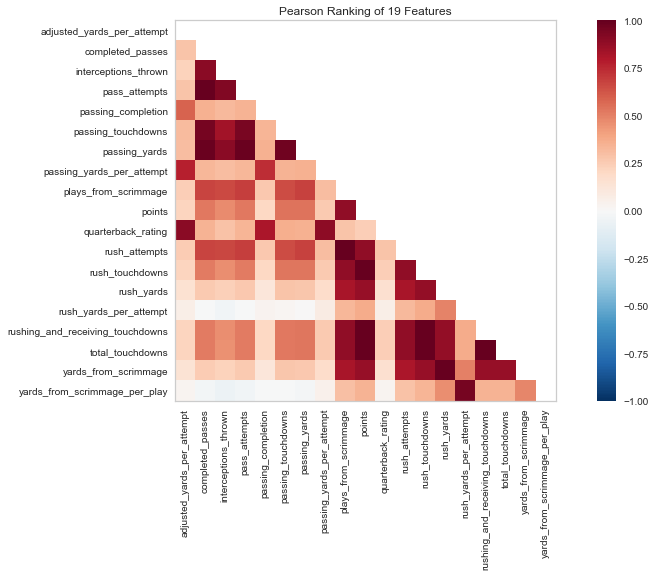

In [255]:
#set up the figure size
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7)

# import the package for visulization of the correlation
from yellowbrick.features import Rank2D

num_features = ['adjusted_yards_per_attempt', 'completed_passes', 'interceptions_thrown', 'pass_attempts', 
'passing_completion', 'passing_touchdowns', 'passing_yards', 'passing_yards_per_attempt', 'plays_from_scrimmage',
'points', 'quarterback_rating', 'rush_attempts','rush_touchdowns', 'rush_yards', 'rush_yards_per_attempt',
'rushing_and_receiving_touchdowns', 'total_touchdowns', 'yards_from_scrimmage', 'yards_from_scrimmage_per_play']

# extract the numpy arrays from the data frame
x = X[num_features].values

# instantiate the visualizer with the Covariance ranking algorithm
visualizer = Rank2D(features=num_features, algorithm='pearson')
visualizer.fit(x)                # Fit the data to the visualizer
visualizer.transform(x)             # Transform the data
visualizer.poof(outpath="pcoords1.png") # Draw/show/poof the data
plt.show()

Based on this information, there are a handful of features that can be eliminated due to their high correlation.  I will need to keep those features that have more orignal data than thsoe that had fill in values of 0.  After determining this, delete those features and re-run the feature importance selections.

I am going to eliminate the following features based on the above correlation matrix:

adjusted_yards_per_attempt, completed_passes, pass_attempts, passing_touchdowns, passing_yards_per_attempt, points, rush_attempts, rush_touchdowns, rush_yards, rush_yards_per_attempt,
total_touchdowns

In [256]:
# need to drop columns that are something other than numbers (name, player_id, position, season, Player)
final_df = final_df.drop(columns=['adjusted_yards_per_attempt', 'completed_passes', 'pass_attempts', 'passing_touchdowns', 'passing_yards_per_attempt', 'points', 
'rush_attempts', 'rush_touchdowns', 'rush_yards', 'rush_yards_per_attempt','total_touchdowns'
])
# final_df = final_df.reset_index()
final_df = final_df.drop(columns=['index'])
final_df = final_df.drop(columns=['level_0'])

final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1438 entries, 0 to 1437
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   interceptions_thrown              1438 non-null   float64
 1   passing_completion                1438 non-null   float64
 2   passing_yards                     1438 non-null   float64
 3   plays_from_scrimmage              1438 non-null   float64
 4   quarterback_rating                1438 non-null   float64
 5   rushing_and_receiving_touchdowns  1438 non-null   float64
 6   yards_from_scrimmage              1438 non-null   float64
 7   yards_from_scrimmage_per_play     1438 non-null   float64
 8   Successful_QB                     1438 non-null   float64
dtypes: float64(9)
memory usage: 101.2 KB


Now we will look at the Pearson Correlation Matrix with the features removed that are highly correlated

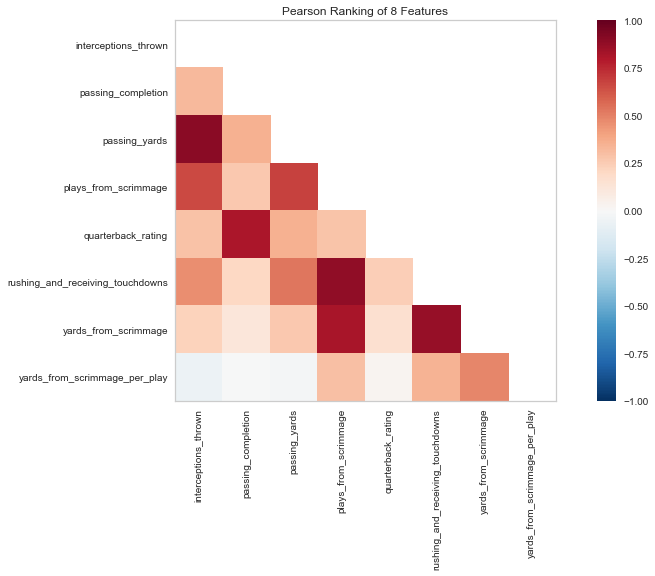

In [257]:
#set up the figure size
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7)

# import the package for visulization of the correlation
from yellowbrick.features import Rank2D

num_features = ['interceptions_thrown', 'passing_completion','passing_yards', 'plays_from_scrimmage','quarterback_rating', 
'rushing_and_receiving_touchdowns', 'yards_from_scrimmage', 'yards_from_scrimmage_per_play']

# extract the numpy arrays from the data frame
x = X[num_features].values

# instantiate the visualizer with the Covariance ranking algorithm
visualizer = Rank2D(features=num_features, algorithm='pearson')
visualizer.fit(x)                # Fit the data to the visualizer
visualizer.transform(x)             # Transform the data
visualizer.poof(outpath="pcoords2.png") # Draw/show/poof the data
plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1438 entries, 0 to 1437
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   interceptions_thrown              1438 non-null   float64
 1   passing_completion                1438 non-null   float64
 2   passing_yards                     1438 non-null   float64
 3   plays_from_scrimmage              1438 non-null   float64
 4   quarterback_rating                1438 non-null   float64
 5   rushing_and_receiving_touchdowns  1438 non-null   float64
 6   yards_from_scrimmage              1438 non-null   float64
 7   yards_from_scrimmage_per_play     1438 non-null   float64
 8   Successful_QB                     1438 non-null   float64
dtypes: float64(9)
memory usage: 101.2 KB
None
Feature: 0 is interceptions_thrown and the score is: 0.14525
Feature: 1 is passing_completion and the score is: -0.00732
Feature: 2 is passing_yards and t

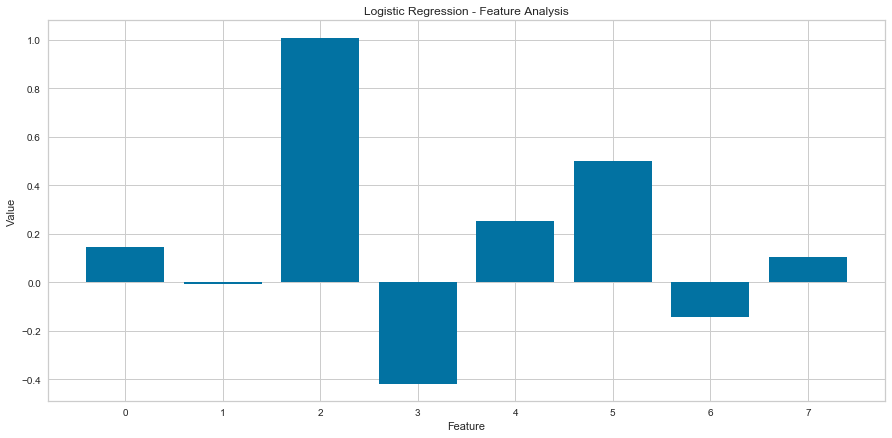

In [258]:
# Ready for feature importance selection.
# Using Logistic Regression
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

print(final_df.info())
model = LogisticRegression()
X = final_df.loc[:,final_df.columns != 'Successful_QB']
y = final_df['Successful_QB']

columns = X.columns
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_std = pd.DataFrame(X_std, columns = columns)
model.fit(X_std,y)

importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature:', str(i), 'is', X.columns[i], 'and the score is: %.5f' % (v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.title('Logistic Regression - Feature Analysis')
plt.xlabel('Feature')
plt.ylabel('Value')
plt.show()

Feature: 0 is interceptions_thrown and the score is: 0.09095
Feature: 1 is passing_completion and the score is: 0.12207
Feature: 2 is passing_yards and the score is: 0.27476
Feature: 3 is plays_from_scrimmage and the score is: 0.07097
Feature: 4 is quarterback_rating and the score is: 0.12857
Feature: 5 is rushing_and_receiving_touchdowns and the score is: 0.04547
Feature: 6 is yards_from_scrimmage and the score is: 0.21334
Feature: 7 is yards_from_scrimmage_per_play and the score is: 0.05388


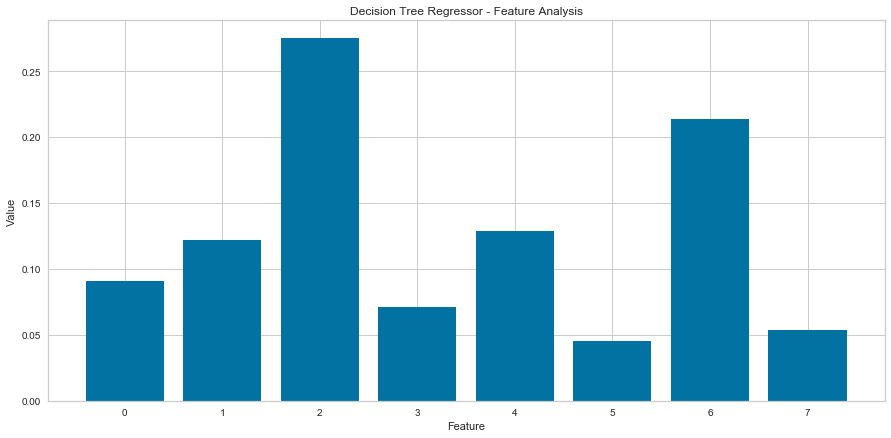

In [259]:
# Using Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

model = DecisionTreeRegressor()

model.fit(X_std,y)
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
		print('Feature:', str(i), 'is', X.columns[i], 'and the score is: %.5f' % (v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.title('Decision Tree Regressor - Feature Analysis')
plt.xlabel('Feature')
plt.ylabel('Value')
plt.show()

Feature: 0 is interceptions_thrown and the score is: 0.07268
Feature: 1 is passing_completion and the score is: 0.14947
Feature: 2 is passing_yards and the score is: 0.27476
Feature: 3 is plays_from_scrimmage and the score is: 0.12184
Feature: 4 is quarterback_rating and the score is: 0.11683
Feature: 5 is rushing_and_receiving_touchdowns and the score is: 0.04286
Feature: 6 is yards_from_scrimmage and the score is: 0.09893
Feature: 7 is yards_from_scrimmage_per_play and the score is: 0.12263


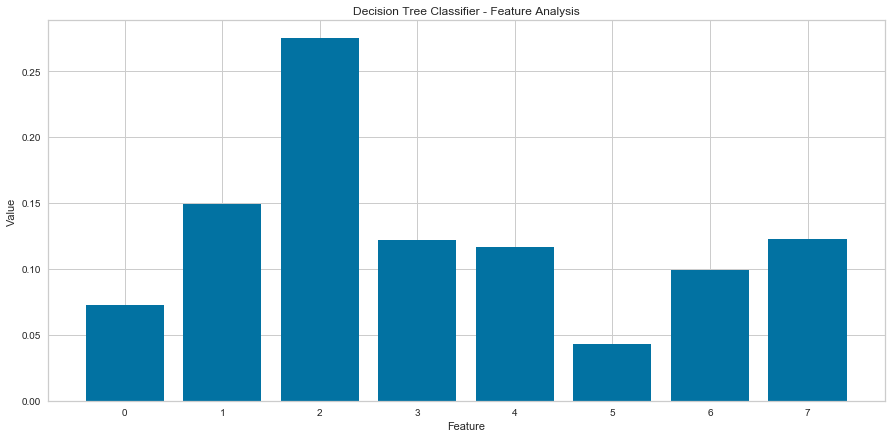

In [260]:
# Using Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

model = DecisionTreeClassifier()

model.fit(X_std,y)
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature:', str(i), 'is', X.columns[i], 'and the score is: %.5f' % (v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.title('Decision Tree Classifier - Feature Analysis')
plt.xlabel('Feature')
plt.ylabel('Value')
plt.show()

Feature: 0 is interceptions_thrown and the score is: 0.08306
Feature: 1 is passing_completion and the score is: 0.12905
Feature: 2 is passing_yards and the score is: 0.26749
Feature: 3 is plays_from_scrimmage and the score is: 0.10917
Feature: 4 is quarterback_rating and the score is: 0.14338
Feature: 5 is rushing_and_receiving_touchdowns and the score is: 0.09140
Feature: 6 is yards_from_scrimmage and the score is: 0.09088
Feature: 7 is yards_from_scrimmage_per_play and the score is: 0.08558


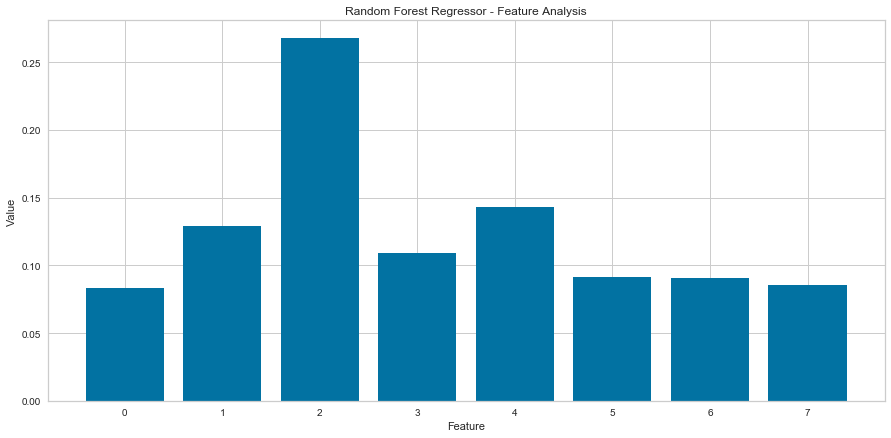

In [261]:
# Using Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

model = RandomForestRegressor()

model.fit(X_std,y)
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature:', str(i), 'is', X.columns[i], 'and the score is: %.5f' % (v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.title('Random Forest Regressor - Feature Analysis')
plt.xlabel('Feature')
plt.ylabel('Value')
plt.show()

Feature: 0 is interceptions_thrown and the score is: 0.12298
Feature: 1 is passing_completion and the score is: 0.10862
Feature: 2 is passing_yards and the score is: 0.18538
Feature: 3 is plays_from_scrimmage and the score is: 0.12704
Feature: 4 is quarterback_rating and the score is: 0.14069
Feature: 5 is rushing_and_receiving_touchdowns and the score is: 0.08672
Feature: 6 is yards_from_scrimmage and the score is: 0.12304
Feature: 7 is yards_from_scrimmage_per_play and the score is: 0.10552


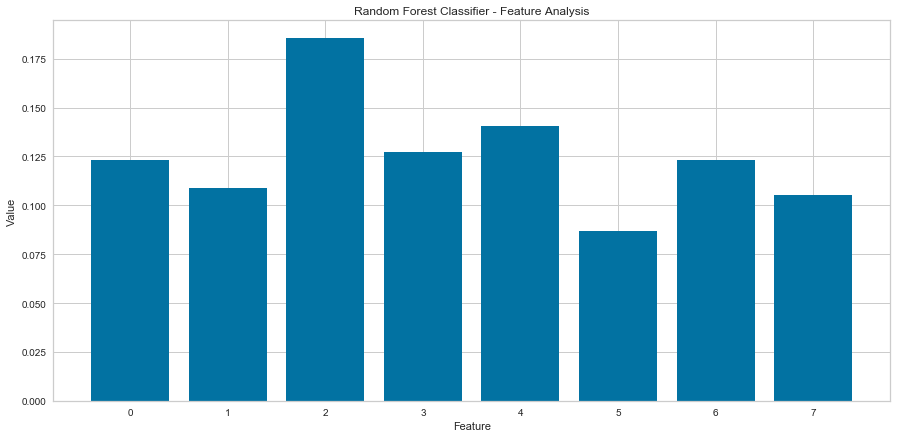

In [262]:
# Using Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

model = RandomForestClassifier()

model.fit(X_std,y)
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature:', str(i), 'is', X.columns[i], 'and the score is: %.5f' % (v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.title('Random Forest Classifier - Feature Analysis')
plt.xlabel('Feature')
plt.ylabel('Value')
plt.show()

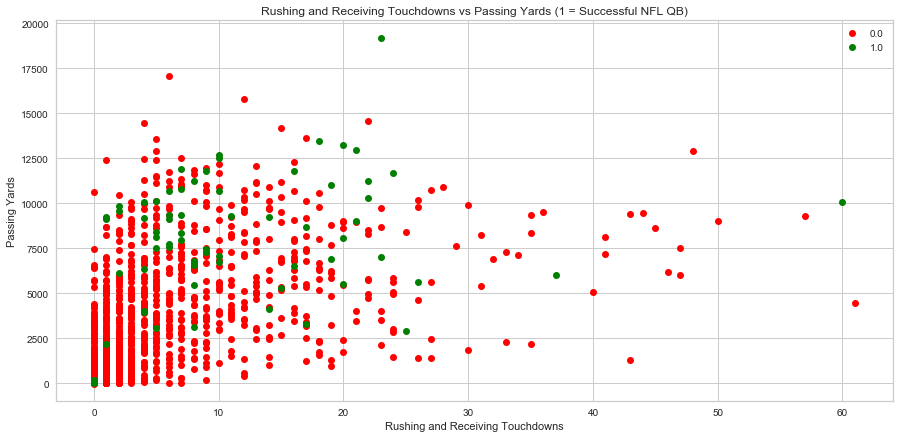

In [267]:
import matplotlib.pyplot as plt
groups = final_df.groupby('Successful_QB')
colors = {0.0:'red', 1.0:'green',}

for name, group in groups:
    plt.plot(group['rushing_and_receiving_touchdowns'], group['passing_yards'], marker='o', linestyle='', label=name, color=colors[name])
plt.xlabel('Rushing and Receiving Touchdowns')
plt.ylabel('Passing Yards')
plt.title('Rushing and Receiving Touchdowns vs Passing Yards (1 = Successful NFL QB)')
plt.legend()
plt.savefig('comp_vs_pass_att.png')

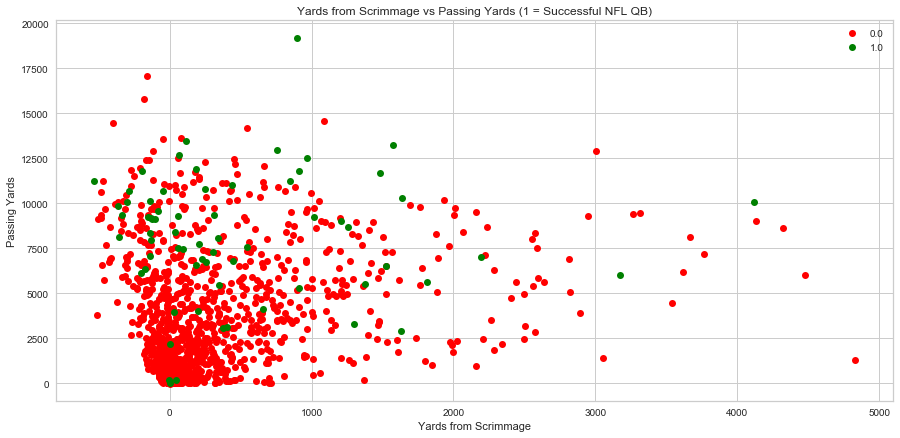

In [270]:
import matplotlib.pyplot as plt
groups = final_df.groupby('Successful_QB')
colors = {0.0:'red', 1.0:'green',}

for name, group in groups:
    plt.plot(group['yards_from_scrimmage'], group['passing_yards'], marker='o', linestyle='', label=name, color=colors[name])
plt.xlabel('Yards from Scrimmage')
plt.ylabel('Passing Yards')
plt.title('Yards from Scrimmage vs Passing Yards (1 = Successful NFL QB)')
plt.legend()
plt.savefig('yfs_vs_pass_yds.png')

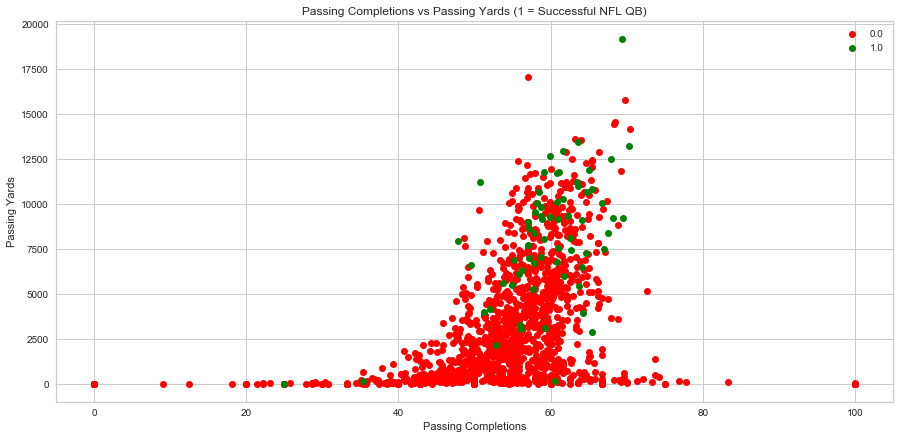

In [272]:
import matplotlib.pyplot as plt
groups = final_df.groupby('Successful_QB')
colors = {0.0:'red', 1.0:'green',}

for name, group in groups:
    plt.plot(group['passing_completion'], group['passing_yards'], marker='o', linestyle='', label=name, color=colors[name])
plt.xlabel('Passing Completions')
plt.ylabel('Passing Yards')
plt.title('Passing Completions vs Passing Yards (1 = Successful NFL QB)')
plt.legend()
plt.savefig('pc_vs_pass_yds.png')

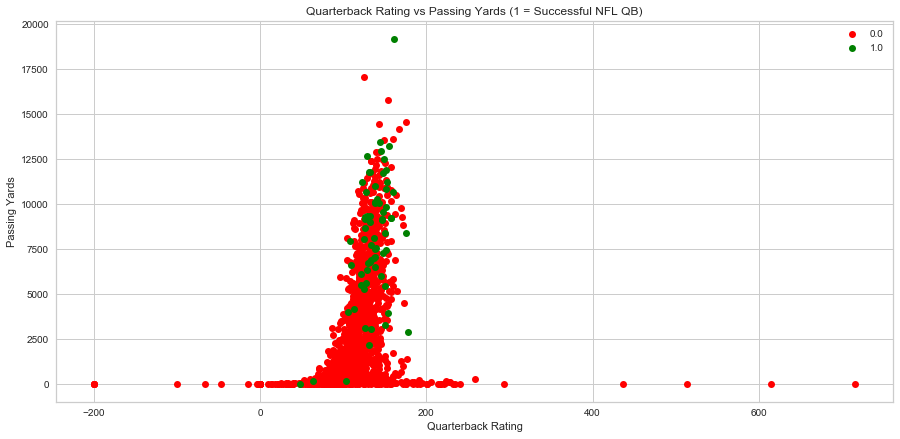

In [273]:
import matplotlib.pyplot as plt
groups = final_df.groupby('Successful_QB')
colors = {0.0:'red', 1.0:'green',}

for name, group in groups:
    plt.plot(group['quarterback_rating'], group['passing_yards'], marker='o', linestyle='', label=name, color=colors[name])
plt.xlabel('Quarterback Rating')
plt.ylabel('Passing Yards')
plt.title('Quarterback Rating vs Passing Yards (1 = Successful NFL QB)')
plt.legend()
plt.savefig('qbr_vs_pass_yds.png')

In [275]:
final_df.groupby('Successful_QB')['passing_yards'].mean()

Successful_QB
0.0    2941.504012
1.0    8101.134328
Name: passing_yards, dtype: float64

In [276]:
final_df.groupby('Successful_QB')['quarterback_rating'].mean()

Successful_QB
0.0    108.635011
1.0    135.568657
Name: quarterback_rating, dtype: float64

In [277]:
final_df.groupby('Successful_QB')['rushing_and_receiving_touchdowns'].mean()


Successful_QB
0.0     4.740336
1.0    11.582090
Name: rushing_and_receiving_touchdowns, dtype: float64

In [278]:
final_df.groupby('Successful_QB')['passing_completion'].mean()


Successful_QB
0.0    51.052152
1.0    59.395522
Name: passing_completion, dtype: float64

In [279]:
final_df.groupby('Successful_QB')['yards_from_scrimmage'].mean()


Successful_QB
0.0    272.113056
1.0    490.656716
Name: yards_from_scrimmage, dtype: float64